# 1: Imports and Setup

In [1]:

import os
import sys
import json
import gc
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import torch_geometric
from pathlib import Path
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Add the parent directory to the Python path
# This allows importing the gnn_dta_mtl package
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

# Import your package - use absolute import instead of relative
from gnn_dta_mtl import (
    MTL_DTAModel, DTAModel,
    MTL_DTA, DTA,
    CrossValidator, MTLTrainer,
    StructureStandardizer, StructureProcessor, StructureChunkLoader,
    ESMEmbedder,
    add_molecular_properties_parallel,
    compute_ligand_efficiency,
    compute_mean_ligand_efficiency,
    filter_by_properties,
    prepare_mtl_experiment,
    build_mtl_dataset, build_mtl_dataset_optimized,
    evaluate_model,
    plot_results, plot_predictions, create_summary_report,
    ExperimentLogger,
    save_model, save_results, create_output_dir
)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda
GPU: NVIDIA L4
Number of GPUs: 1


# 2: Configuration


In [2]:
import os
import json
from pathlib import Path
from datetime import datetime

# Create necessary directories first
base_dirs = [
    '../input/combined',
    '../input/chunk',
    '../input/embeddings',
    '../output/protein',
    '../output/ligand',
    '../output/experiments',
]

for dir_path in base_dirs:
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    print(f"✓ Created: {dir_path}")

CONFIG = {
    # Data paths
    'data_path': '../input/combined/df_combined.parquet',
    'protein_out_dir': '../output/protein',
    'ligand_out_dir': '../output/ligand',
    'structure_chunks_dir': '../input/chunk/',
    'embeddings_dir': '../input/embeddings/',
    'output_dir': '../output/experiments/',
    
    # Task configuration
    'task_cols': ['pKi', 'pEC50', 'pKd (Wang, FEP)', 'pKd', 'pIC50', 'potency'],
    
    # Model configuration
    'model_config': {
        'prot_emb_dim': 1280,
        'prot_gcn_dims': [128, 256, 256],
        'prot_fc_dims': [1024, 128],
        'drug_node_in_dim': [66, 1],
        'drug_node_h_dims': [128, 64],
        'drug_edge_in_dim': [16, 1],
        'drug_edge_h_dims': [32, 1],
        'drug_fc_dims': [1024, 128],
        'mlp_dims': [1024, 512],
        'mlp_dropout': 0.25
    },
    
    # Training configuration
    'training_config': {
        'batch_size': 128,
        'n_epochs': 200,
        'learning_rate': 0.0005,
        'patience': 100,
        'n_folds': 3
    },
    
    # Data filtering
    'filter_config': {
        'min_heavy_atoms': 5,
        'max_heavy_atoms': 75,
        'max_mw': 1000,
        'min_carbons': 4,
        'min_le': 0.05,
        'max_le_norm': 0.003
    },
    
    # Processing
    'n_workers': os.cpu_count() - 1 if os.cpu_count() else 8,
    'chunk_size': 100000,
    'sample_size': None,  # Set to integer to limit data size for testing
    
    # ESM model
    'esm_model_name': 'facebook/esm2_t33_650M_UR50D'
}

# Create experiment directory with timestamp
experiment_name = 'gnn_dta_mtl_experiment'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_dir = Path(CONFIG['output_dir']) / f"{experiment_name}_{timestamp}"

# Create subdirectories
(experiment_dir / 'models').mkdir(parents=True, exist_ok=True)
(experiment_dir / 'results').mkdir(parents=True, exist_ok=True)
(experiment_dir / 'figures').mkdir(parents=True, exist_ok=True)
(experiment_dir / 'logs').mkdir(parents=True, exist_ok=True)

CONFIG['experiment_dir'] = str(experiment_dir)

# Save configuration
config_path = experiment_dir / 'config.json'
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2)

print(f"✓ Experiment directory: {CONFIG['experiment_dir']}")
print(f"✓ Configuration saved to: {config_path}")

✓ Created: ../input/combined
✓ Created: ../input/chunk
✓ Created: ../input/embeddings
✓ Created: ../output/protein
✓ Created: ../output/ligand
✓ Created: ../output/experiments
✓ Experiment directory: ../output/experiments/gnn_dta_mtl_experiment_20250910_153508
✓ Configuration saved to: ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/config.json


# 3 : Prepare MTL Experiment

In [3]:
df = pd.read_parquet("./binding_set.parquet")

In [4]:

# Calculate task ranges for weighting
task_ranges = prepare_mtl_experiment(df, CONFIG['task_cols'])

# Create task statistics
print("\nTask Statistics:")
for task in CONFIG['task_cols']:
    if task in df.columns:
        valid_values = df[task].dropna()
        if len(valid_values) > 0:
            print(f"{task}:")
            print(f"  Count: {len(valid_values)}")
            print(f"  Mean: {valid_values.mean():.2f}")
            print(f"  Std: {valid_values.std():.2f}")
            print(f"  Range: [{valid_values.min():.2f}, {valid_values.max():.2f}]")

Task ranges for weighting:
  pKi: range=8.88, weight=0.0455
  pEC50: range=7.47, weight=0.0541
  pKd (Wang, FEP): range=1.00, weight=0.4039
  pKd: range=10.11, weight=0.0400
  pIC50: range=7.67, weight=0.0527
  potency: range=1.00, weight=0.4039

Task Statistics:
pKi:
  Count: 1383
  Mean: 6.72
  Std: 1.86
  Range: [3.04, 11.92]
pEC50:
  Count: 183
  Mean: 7.29
  Std: 1.67
  Range: [3.42, 10.89]
pKd:
  Count: 952
  Mean: 6.78
  Std: 1.86
  Range: [3.01, 13.11]
pIC50:
  Count: 1278
  Mean: 6.91
  Std: 1.47
  Range: [3.01, 10.68]


# 4 : Cross-Validation Training

In [5]:
from rdkit import RDLogger

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')


In [6]:
# Cell 9: Cross-Validation Training
# Initialize cross-validator
cv = CrossValidator(
    model_config=CONFIG['model_config'],
    task_cols=CONFIG['task_cols'],
    task_ranges=task_ranges,
    n_folds=CONFIG['training_config']['n_folds'],
    batch_size=CONFIG['training_config']['batch_size'],
    n_epochs=CONFIG['training_config']['n_epochs'],
    learning_rate=CONFIG['training_config']['learning_rate'],
    patience=CONFIG['training_config']['patience'],
    device=device,
    seed=SEED
)


In [7]:
CONFIG['task_cols']

['pKi', 'pEC50', 'pKd (Wang, FEP)', 'pKd', 'pIC50', 'potency']

In [8]:

# Create chunk loader
chunk_loader = StructureChunkLoader(
    chunk_dir=CONFIG['structure_chunks_dir'],
    cache_size=2
)



Loaded 3796 structures from 1 chunks


In [9]:

# Run cross-validation
print("\nStarting cross-validation...")
cv_results = cv.run(df, chunk_loader)



Starting cross-validation...

Starting 3-fold cross-validation...

Fold 1 sizes:
  Train: 2277
  Valid: 253
  Test:  1266
Loading structures for 2277 unique proteins...


Building dataset: 100%|██████████| 2277/2277 [02:31<00:00, 14.98it/s]


Loading structures for 253 unique proteins...


Building dataset: 100%|██████████| 253/253 [00:16<00:00, 15.01it/s]


Loading structures for 1266 unique proteins...


Building dataset: 100%|██████████| 1266/1266 [01:07<00:00, 18.81it/s]



FOLD 1/3


Evaluating: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]



Fold 2 sizes:
  Train: 2278
  Valid: 253
  Test:  1265
Loading structures for 2278 unique proteins...


Building dataset: 100%|██████████| 2278/2278 [00:28<00:00, 80.56it/s]


Loading structures for 253 unique proteins...


Building dataset: 100%|██████████| 253/253 [00:03<00:00, 81.76it/s]


Loading structures for 1265 unique proteins...


Building dataset: 100%|██████████| 1265/1265 [00:17<00:00, 72.99it/s]



FOLD 2/3


Evaluating: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]



Fold 3 sizes:
  Train: 2278
  Valid: 253
  Test:  1265
Loading structures for 2278 unique proteins...


Building dataset: 100%|██████████| 2278/2278 [00:34<00:00, 65.16it/s]


Loading structures for 253 unique proteins...


Building dataset: 100%|██████████| 253/253 [00:03<00:00, 71.15it/s]


Loading structures for 1265 unique proteins...


Building dataset: 100%|██████████| 1265/1265 [00:17<00:00, 73.84it/s]



FOLD 3/3


Evaluating: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


In [10]:
# Print summary
cv.print_summary()

# Save CV results
save_results(
    cv_results, 
    os.path.join(CONFIG['experiment_dir'], 'results', 'cv_results.pkl'),
    format='pickle'
)


CROSS-VALIDATION SUMMARY

pKi:
  R²:    0.659 ± 0.039
  RMSE:  1.079 ± 0.062
  Total samples: 1383

pEC50:
  R²:    0.785 ± 0.036
  RMSE:  0.758 ± 0.051
  Total samples: 183

pKd:
  R²:    0.717 ± 0.069
  RMSE:  0.985 ± 0.170
  Total samples: 952

pIC50:
  R²:    0.642 ± 0.067
  RMSE:  0.873 ± 0.085
  Total samples: 1278
Results saved to ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/results/cv_results.pkl


# 4 : Full Training on All Data

In [ ]:
# Create train/valid/test splits
from gnn_dta_mtl.datasets import create_data_splits

splits = create_data_splits(
    df,
    split_method='random',  # or 'scaffold', 'protein', 'drug'
    split_frac=[0.7, 0.1, 0.2],
    seed=SEED
)

df_train = splits['train']
df_valid = splits['valid']
df_test = splits['test']

print(f"Train: {len(df_train)}, Valid: {len(df_valid)}, Test: {len(df_test)}")

# Build datasets
train_dataset = build_mtl_dataset_optimized(df_train, chunk_loader, CONFIG['task_cols'])
valid_dataset = build_mtl_dataset_optimized(df_valid, chunk_loader, CONFIG['task_cols'])
test_dataset = build_mtl_dataset_optimized(df_test, chunk_loader, CONFIG['task_cols'])

# Create data loaders
train_loader = torch_geometric.loader.DataLoader(
    train_dataset,
    batch_size=CONFIG['training_config']['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

valid_loader = torch_geometric.loader.DataLoader(
    valid_dataset,
    batch_size=CONFIG['training_config']['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = torch_geometric.loader.DataLoader(
    test_dataset,
    batch_size=CONFIG['training_config']['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Create model
model = MTL_DTAModel(
    task_names=CONFIG['task_cols'],
    **CONFIG['model_config']
).to(device)

# Initialize trainer
trainer = MTLTrainer(
    model=model,
    task_cols=CONFIG['task_cols'],
    task_ranges=task_ranges,
    device=device,
    learning_rate=CONFIG['training_config']['learning_rate']
)

# Train model
print("\nTraining model...")
history = trainer.train(
    train_loader,
    valid_loader,
    n_epochs=CONFIG['training_config']['n_epochs'],
    patience=CONFIG['training_config']['patience'],
    verbose=True
)

# Save model
save_model(
    model,
    os.path.join(CONFIG['experiment_dir'], 'models', 'final_model.pt'),
    metrics=history
)

Train: 2657, Valid: 380, Test: 759
Loading structures for 2657 unique proteins...


Building dataset: 100%|██████████| 2657/2657 [00:42<00:00, 62.86it/s]


Loading structures for 380 unique proteins...


Building dataset: 100%|██████████| 380/380 [00:05<00:00, 73.49it/s]


Loading structures for 759 unique proteins...


Building dataset: 100%|██████████| 759/759 [00:10<00:00, 71.25it/s]



Training model...


Training: 100%|██████████| 21/21 [00:11<00:00,  1.86it/s]



Epoch 1/200
  Train Loss: 0.5135
  Valid Loss: 0.1408
  pKi: RMSE=1.821, R²=-0.126
  pEC50: RMSE=2.053, R²=-0.442
  pKd: RMSE=1.913, R²=-0.056
  pIC50: RMSE=1.499, R²=0.084


Training: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]



Epoch 2/200
  Train Loss: 0.1428
  Valid Loss: 0.0984
  pKi: RMSE=1.420, R²=0.315
  pEC50: RMSE=1.508, R²=0.222
  pKd: RMSE=1.707, R²=0.159
  pIC50: RMSE=1.316, R²=0.294


Training: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]



Epoch 3/200
  Train Loss: 0.1188
  Valid Loss: 0.0983
  pKi: RMSE=1.460, R²=0.276
  pEC50: RMSE=1.365, R²=0.363
  pKd: RMSE=1.802, R²=0.064
  pIC50: RMSE=1.232, R²=0.382


Training: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]



Epoch 4/200
  Train Loss: 0.1115
  Valid Loss: 0.0906
  pKi: RMSE=1.388, R²=0.346
  pEC50: RMSE=1.355, R²=0.372
  pKd: RMSE=1.548, R²=0.309
  pIC50: RMSE=1.304, R²=0.307


Training: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]



Epoch 5/200
  Train Loss: 0.1064
  Valid Loss: 0.0860
  pKi: RMSE=1.394, R²=0.340
  pEC50: RMSE=1.414, R²=0.316
  pKd: RMSE=1.573, R²=0.287
  pIC50: RMSE=1.180, R²=0.432


Training: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 6/200
  Train Loss: 0.0930
  Valid Loss: 0.0844
  pKi: RMSE=1.358, R²=0.374
  pEC50: RMSE=1.262, R²=0.455
  pKd: RMSE=1.503, R²=0.348
  pIC50: RMSE=1.241, R²=0.372


Training: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 7/200
  Train Loss: 0.0957
  Valid Loss: 0.0812
  pKi: RMSE=1.313, R²=0.414
  pEC50: RMSE=1.263, R²=0.454
  pKd: RMSE=1.451, R²=0.393
  pIC50: RMSE=1.244, R²=0.369


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 8/200
  Train Loss: 0.0954
  Valid Loss: 0.0772
  pKi: RMSE=1.359, R²=0.373
  pEC50: RMSE=1.246, R²=0.469
  pKd: RMSE=1.382, R²=0.449
  pIC50: RMSE=1.152, R²=0.459


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 9/200
  Train Loss: 0.0910
  Valid Loss: 0.0763
  pKi: RMSE=1.322, R²=0.406
  pEC50: RMSE=1.127, R²=0.565
  pKd: RMSE=1.386, R²=0.446
  pIC50: RMSE=1.181, R²=0.432


Training: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]



Epoch 10/200
  Train Loss: 0.0854
  Valid Loss: 0.0744
  pKi: RMSE=1.303, R²=0.423
  pEC50: RMSE=1.153, R²=0.545
  pKd: RMSE=1.401, R²=0.434
  pIC50: RMSE=1.145, R²=0.466


Training: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]



Epoch 11/200
  Train Loss: 0.0794
  Valid Loss: 0.0719
  pKi: RMSE=1.282, R²=0.442
  pEC50: RMSE=1.083, R²=0.599
  pKd: RMSE=1.368, R²=0.461
  pIC50: RMSE=1.135, R²=0.475


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 12/200
  Train Loss: 0.0773
  Valid Loss: 0.0883
  pKi: RMSE=1.420, R²=0.315
  pEC50: RMSE=1.100, R²=0.586
  pKd: RMSE=1.367, R²=0.461
  pIC50: RMSE=1.347, R²=0.261


Training: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 13/200
  Train Loss: 0.0761
  Valid Loss: 0.0836
  pKi: RMSE=1.476, R²=0.260
  pEC50: RMSE=1.387, R²=0.342
  pKd: RMSE=1.420, R²=0.419
  pIC50: RMSE=1.135, R²=0.475


Training: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]



Epoch 14/200
  Train Loss: 0.0756
  Valid Loss: 0.0735
  pKi: RMSE=1.317, R²=0.411
  pEC50: RMSE=1.086, R²=0.596
  pKd: RMSE=1.333, R²=0.487
  pIC50: RMSE=1.156, R²=0.455


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 15/200
  Train Loss: 0.0703
  Valid Loss: 0.0725
  pKi: RMSE=1.304, R²=0.422
  pEC50: RMSE=0.984, R²=0.669
  pKd: RMSE=1.331, R²=0.489
  pIC50: RMSE=1.158, R²=0.454


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 16/200
  Train Loss: 0.0717
  Valid Loss: 0.0724
  pKi: RMSE=1.323, R²=0.406
  pEC50: RMSE=0.984, R²=0.669
  pKd: RMSE=1.296, R²=0.516
  pIC50: RMSE=1.155, R²=0.457


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 17/200
  Train Loss: 0.0760
  Valid Loss: 0.0709
  pKi: RMSE=1.304, R²=0.423
  pEC50: RMSE=1.053, R²=0.620
  pKd: RMSE=1.271, R²=0.534
  pIC50: RMSE=1.146, R²=0.465


Training: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]



Epoch 18/200
  Train Loss: 0.0741
  Valid Loss: 0.0906
  pKi: RMSE=1.396, R²=0.338
  pEC50: RMSE=0.984, R²=0.669
  pKd: RMSE=1.406, R²=0.430
  pIC50: RMSE=1.401, R²=0.200


Training: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]



Epoch 19/200
  Train Loss: 0.0710
  Valid Loss: 0.0690
  pKi: RMSE=1.267, R²=0.455
  pEC50: RMSE=1.008, R²=0.652
  pKd: RMSE=1.286, R²=0.523
  pIC50: RMSE=1.136, R²=0.474


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 20/200
  Train Loss: 0.0609
  Valid Loss: 0.0692
  pKi: RMSE=1.270, R²=0.452
  pEC50: RMSE=1.022, R²=0.643
  pKd: RMSE=1.298, R²=0.514
  pIC50: RMSE=1.130, R²=0.480


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 21/200
  Train Loss: 0.0668
  Valid Loss: 0.0794
  pKi: RMSE=1.301, R²=0.425
  pEC50: RMSE=0.905, R²=0.720
  pKd: RMSE=1.299, R²=0.513
  pIC50: RMSE=1.327, R²=0.283


Training: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]



Epoch 22/200
  Train Loss: 0.0579
  Valid Loss: 0.0653
  pKi: RMSE=1.235, R²=0.482
  pEC50: RMSE=0.888, R²=0.730
  pKd: RMSE=1.206, R²=0.581
  pIC50: RMSE=1.135, R²=0.475


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 23/200
  Train Loss: 0.0577
  Valid Loss: 0.0641
  pKi: RMSE=1.238, R²=0.480
  pEC50: RMSE=0.774, R²=0.795
  pKd: RMSE=1.215, R²=0.574
  pIC50: RMSE=1.108, R²=0.500


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 24/200
  Train Loss: 0.0645
  Valid Loss: 0.0699
  pKi: RMSE=1.265, R²=0.457
  pEC50: RMSE=0.801, R²=0.781
  pKd: RMSE=1.190, R²=0.592
  pIC50: RMSE=1.223, R²=0.391


Training: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 25/200
  Train Loss: 0.0591
  Valid Loss: 0.0644
  pKi: RMSE=1.230, R²=0.486
  pEC50: RMSE=0.721, R²=0.822
  pKd: RMSE=1.179, R²=0.599
  pIC50: RMSE=1.145, R²=0.465


Training: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]



Epoch 26/200
  Train Loss: 0.0557
  Valid Loss: 0.0661
  pKi: RMSE=1.262, R²=0.459
  pEC50: RMSE=0.818, R²=0.771
  pKd: RMSE=1.221, R²=0.570
  pIC50: RMSE=1.126, R²=0.483


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 27/200
  Train Loss: 0.0588
  Valid Loss: 0.0724
  pKi: RMSE=1.267, R²=0.455
  pEC50: RMSE=1.010, R²=0.651
  pKd: RMSE=1.255, R²=0.546
  pIC50: RMSE=1.228, R²=0.385


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 28/200
  Train Loss: 0.0633
  Valid Loss: 0.0676
  pKi: RMSE=1.215, R²=0.498
  pEC50: RMSE=1.255, R²=0.462
  pKd: RMSE=1.208, R²=0.579
  pIC50: RMSE=1.168, R²=0.444


Training: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]



Epoch 29/200
  Train Loss: 0.0508
  Valid Loss: 0.0626
  pKi: RMSE=1.198, R²=0.513
  pEC50: RMSE=0.673, R²=0.845
  pKd: RMSE=1.162, R²=0.611
  pIC50: RMSE=1.145, R²=0.465


Training: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]



Epoch 30/200
  Train Loss: 0.0529
  Valid Loss: 0.0665
  pKi: RMSE=1.240, R²=0.478
  pEC50: RMSE=0.947, R²=0.693
  pKd: RMSE=1.227, R²=0.566
  pIC50: RMSE=1.142, R²=0.468


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 31/200
  Train Loss: 0.0549
  Valid Loss: 0.0645
  pKi: RMSE=1.211, R²=0.502
  pEC50: RMSE=0.890, R²=0.729
  pKd: RMSE=1.197, R²=0.587
  pIC50: RMSE=1.142, R²=0.468


Training: 100%|██████████| 21/21 [00:11<00:00,  1.86it/s]



Epoch 32/200
  Train Loss: 0.0499
  Valid Loss: 0.0631
  pKi: RMSE=1.235, R²=0.482
  pEC50: RMSE=0.706, R²=0.829
  pKd: RMSE=1.184, R²=0.596
  pIC50: RMSE=1.109, R²=0.499


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 33/200
  Train Loss: 0.0505
  Valid Loss: 0.0653
  pKi: RMSE=1.219, R²=0.495
  pEC50: RMSE=0.813, R²=0.774
  pKd: RMSE=1.268, R²=0.537
  pIC50: RMSE=1.124, R²=0.485


Training: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 34/200
  Train Loss: 0.0472
  Valid Loss: 0.0618
  pKi: RMSE=1.208, R²=0.504
  pEC50: RMSE=0.647, R²=0.857
  pKd: RMSE=1.157, R²=0.614
  pIC50: RMSE=1.121, R²=0.488


Training: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]



Epoch 35/200
  Train Loss: 0.0489
  Valid Loss: 0.0635
  pKi: RMSE=1.273, R²=0.450
  pEC50: RMSE=0.925, R²=0.707
  pKd: RMSE=1.137, R²=0.627
  pIC50: RMSE=1.087, R²=0.518


Training: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 36/200
  Train Loss: 0.0572
  Valid Loss: 0.0594
  pKi: RMSE=1.193, R²=0.517
  pEC50: RMSE=0.631, R²=0.864
  pKd: RMSE=1.126, R²=0.634
  pIC50: RMSE=1.094, R²=0.512


Training: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 37/200
  Train Loss: 0.0490
  Valid Loss: 0.0673
  pKi: RMSE=1.250, R²=0.469
  pEC50: RMSE=0.645, R²=0.858
  pKd: RMSE=1.149, R²=0.619
  pIC50: RMSE=1.208, R²=0.405


Training: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]



Epoch 38/200
  Train Loss: 0.0506
  Valid Loss: 0.0572
  pKi: RMSE=1.128, R²=0.568
  pEC50: RMSE=0.775, R²=0.795
  pKd: RMSE=1.116, R²=0.641
  pIC50: RMSE=1.098, R²=0.508


Training:  19%|█▉        | 4/21 [00:02<00:09,  1.89it/s]

In [ ]:
os.path.join(CONFIG['experiment_dir'], 'models', 'final_model.pt')

# 6 : Evaluate Model

In [22]:
# Evaluate on test set (for full training)
if 'test_loader' in locals():
    print("\nEvaluating on test set...")
    test_results = evaluate_model(model, test_loader, CONFIG['task_cols'], device)
    
    # Print test results
    print("\nTest Results:")
    for task, metrics in test_results.items():
        print(f"\n{task}:")
        for metric_name, value in metrics.items():
            if isinstance(value, float):
                print(f"  {metric_name}: {value:.4f}")
    
    # Save test results
    save_results(
        test_results,
        os.path.join(CONFIG['experiment_dir'], 'results', 'test_results.json'),
        format='json'
    )

# For cross-validation results
else:
    print("\nCross-Validation Summary:")
    summary_df = create_summary_report(
        cv_results,
        CONFIG['task_cols'],
        os.path.join(CONFIG['experiment_dir'], 'results', 'cv_summary.csv')
    )
    print(summary_df)


Evaluating on test set...


Evaluating: 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]


Test Results:

pKi:
  rmse: 1.1071
  mae: 0.7452
  r2: 0.6446
  pearson_p: 0.0000
  spearman_r: 0.8272
  spearman_p: 0.0000
  mape: 0.1138
  c_index: 0.8328

pEC50:
  rmse: 0.9299
  mae: 0.7479
  r2: 0.5662
  pearson_p: 0.0000
  spearman_r: 0.7847
  spearman_p: 0.0000
  mape: 0.1021
  c_index: 0.8268

pKd:
  rmse: 0.9411
  mae: 0.6042
  r2: 0.7743
  pearson_p: 0.0000
  spearman_r: 0.8862
  spearman_p: 0.0000
  mape: 0.1078
  c_index: 0.8714

pIC50:
  rmse: 0.8303
  mae: 0.5552
  r2: 0.6913
  pearson_p: 0.0000
  spearman_r: 0.8460
  spearman_p: 0.0000
  mape: 0.0890
  c_index: 0.8453
Results saved to ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/results/test_results.json


# 7 : Visualization

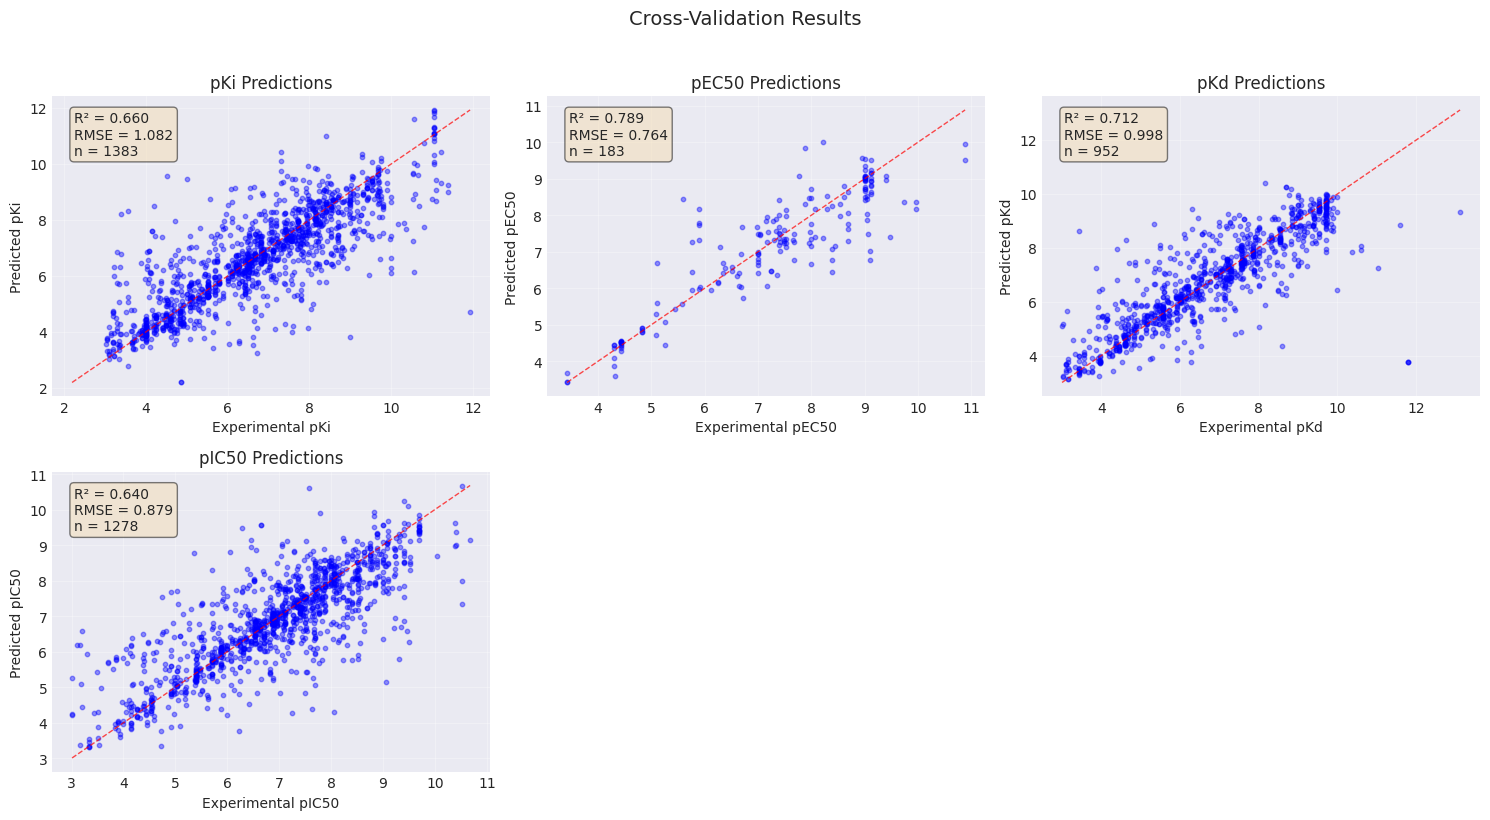

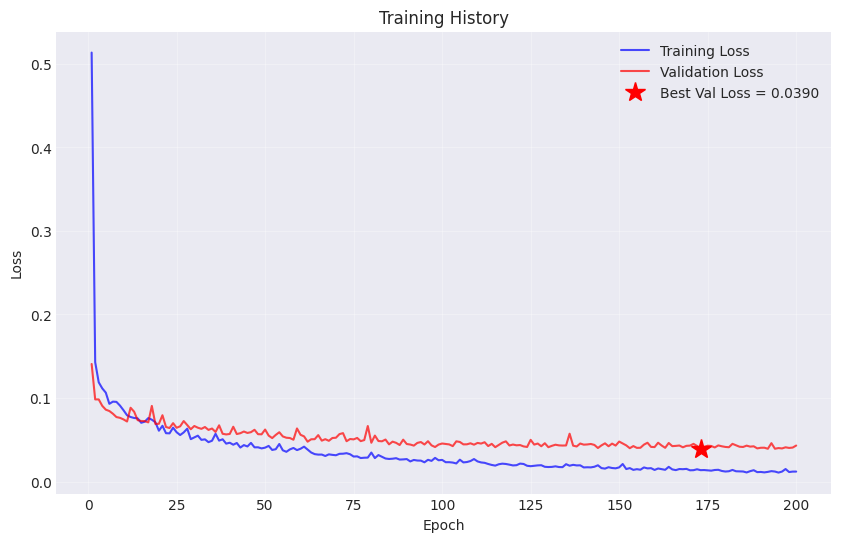

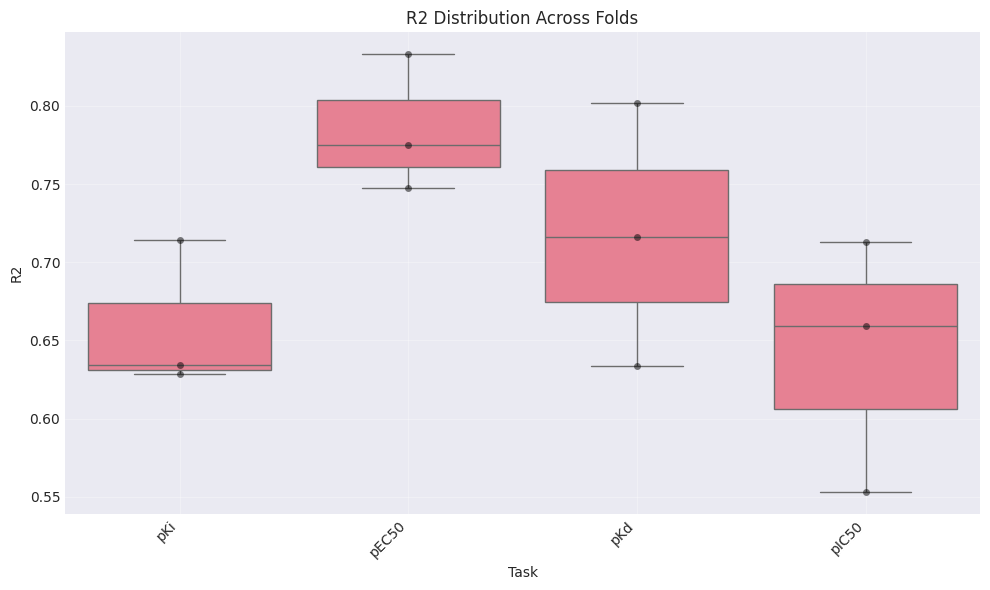

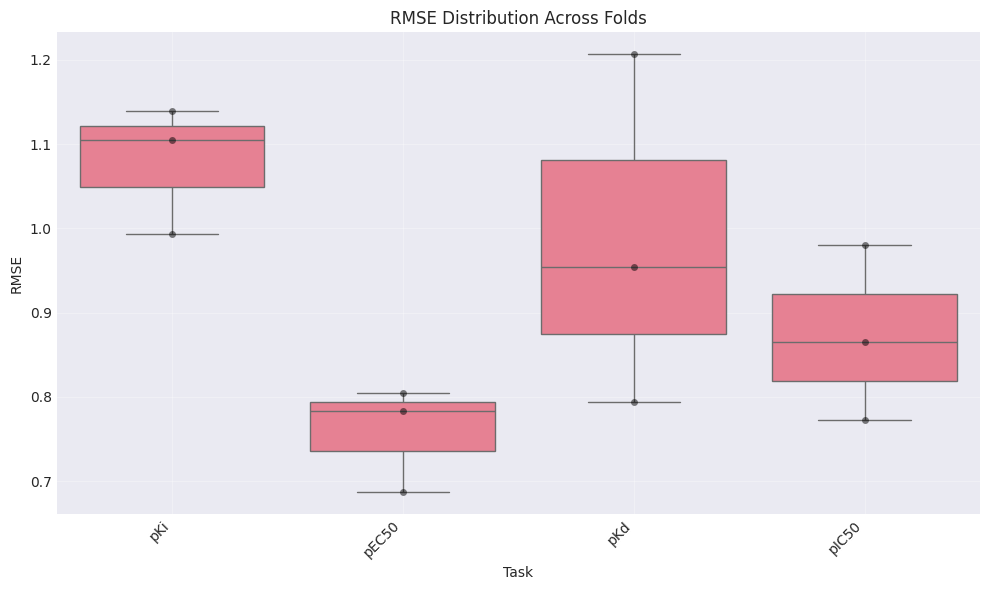

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Plot CV results
if 'cv_results' in locals():
    fig = plot_results(
        cv_results,
        CONFIG['task_cols'],
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'cv_results.png')
    )

# Plot training history
if 'trainer' in locals() and hasattr(trainer, 'train_losses'):
    from gnn_dta_mtl.evaluation.visualization import plot_training_history
    plot_training_history(
        trainer.train_losses,
        trainer.val_losses,
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'training_history.png')
    )

# Plot metrics distribution across folds
if 'cv_results' in locals():
    from gnn_dta_mtl.evaluation.visualization import plot_metrics_distribution
    plot_metrics_distribution(
        cv_results,
        CONFIG['task_cols'],
        metric='r2',
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'r2_distribution.png')
    )
    
    plot_metrics_distribution(
        cv_results,
        CONFIG['task_cols'],
        metric='rmse',
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'rmse_distribution.png')
    )

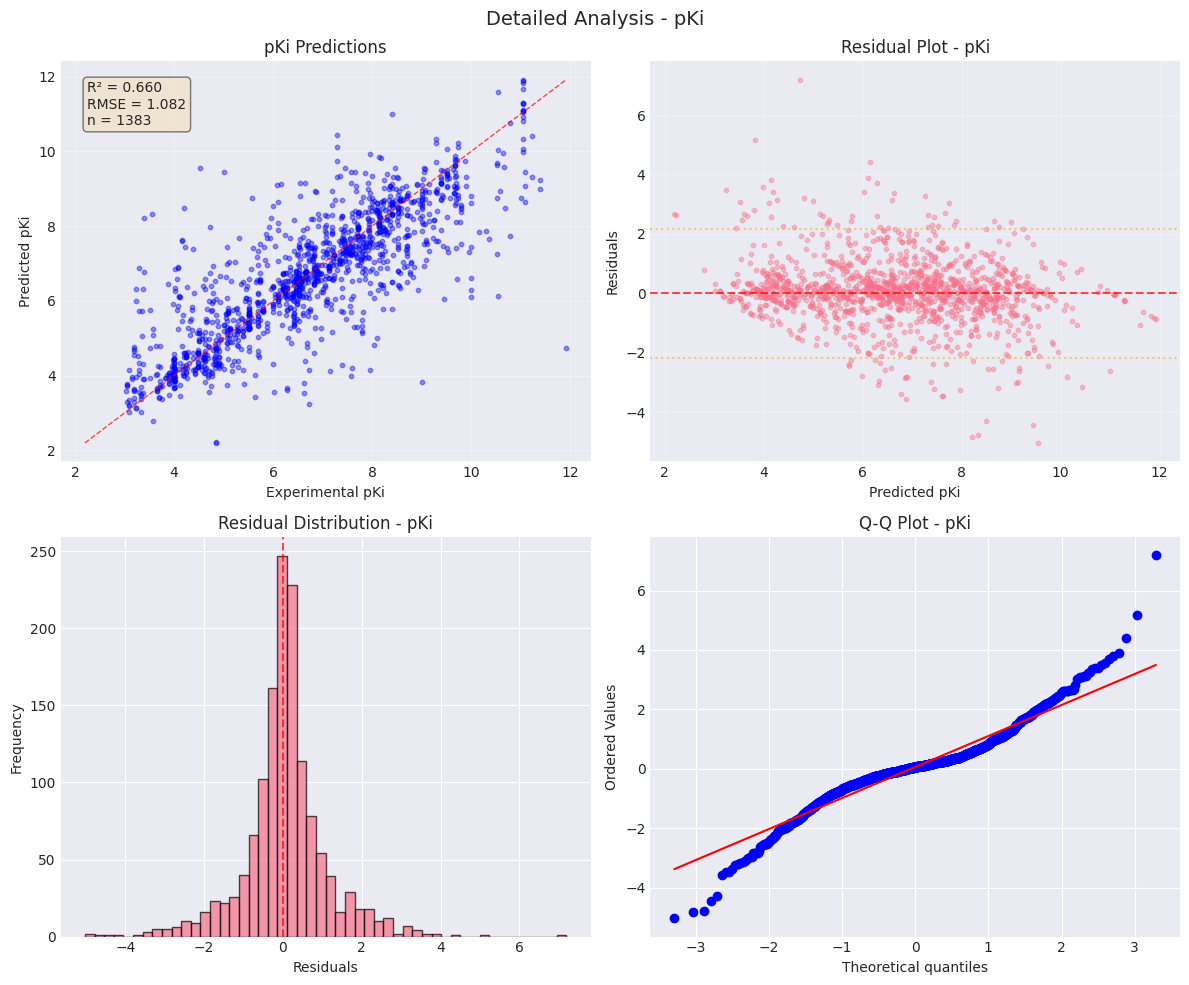

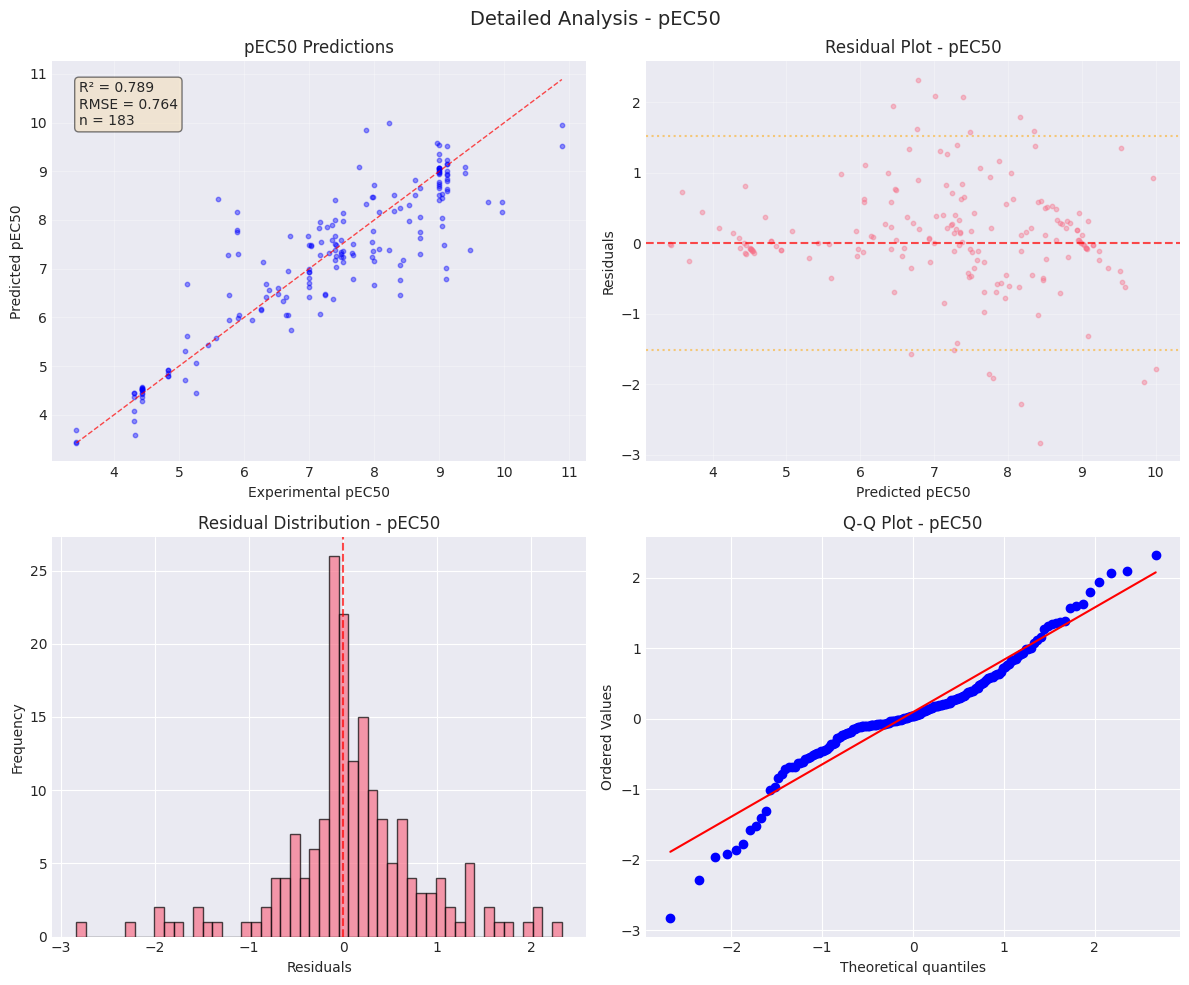

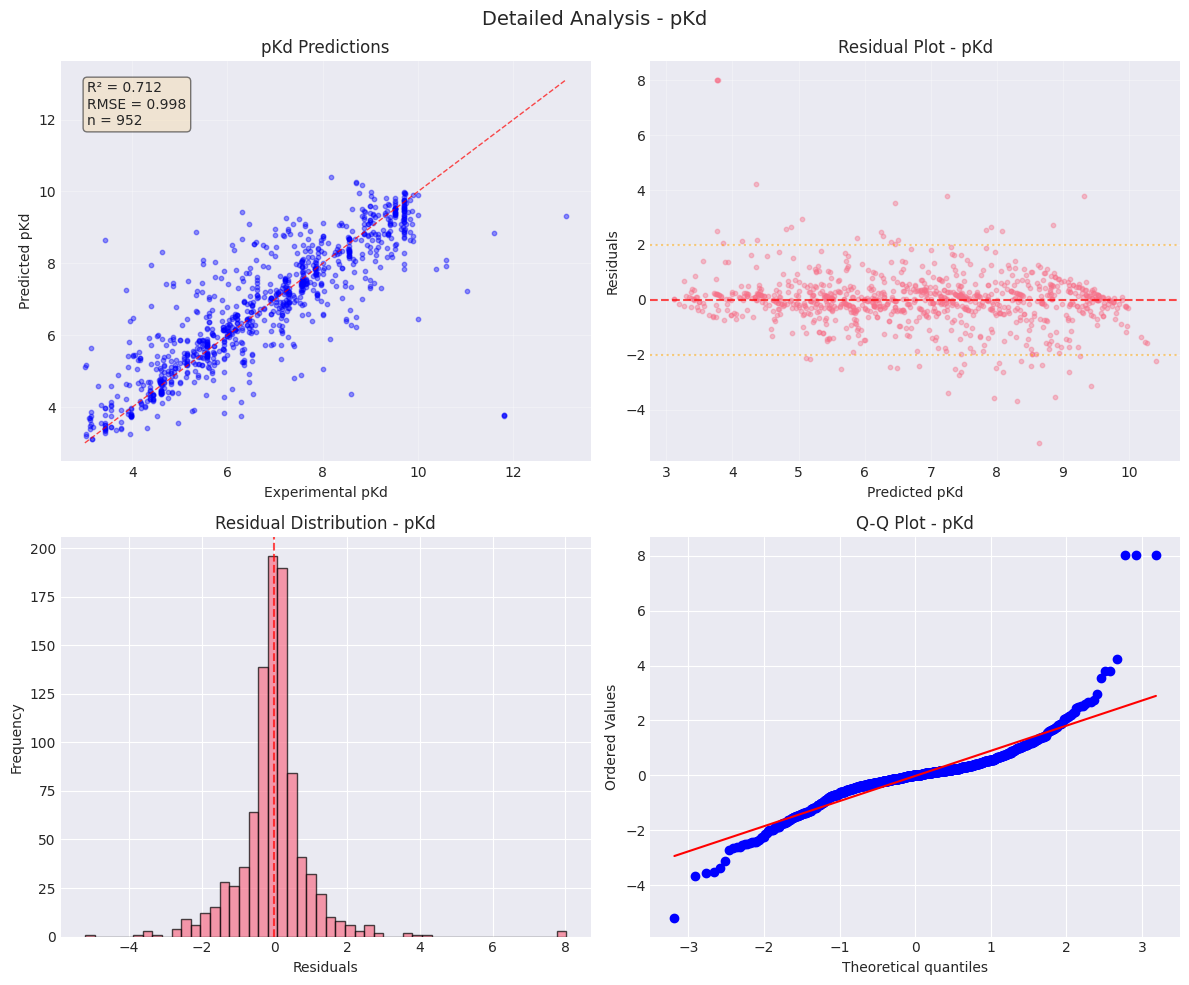

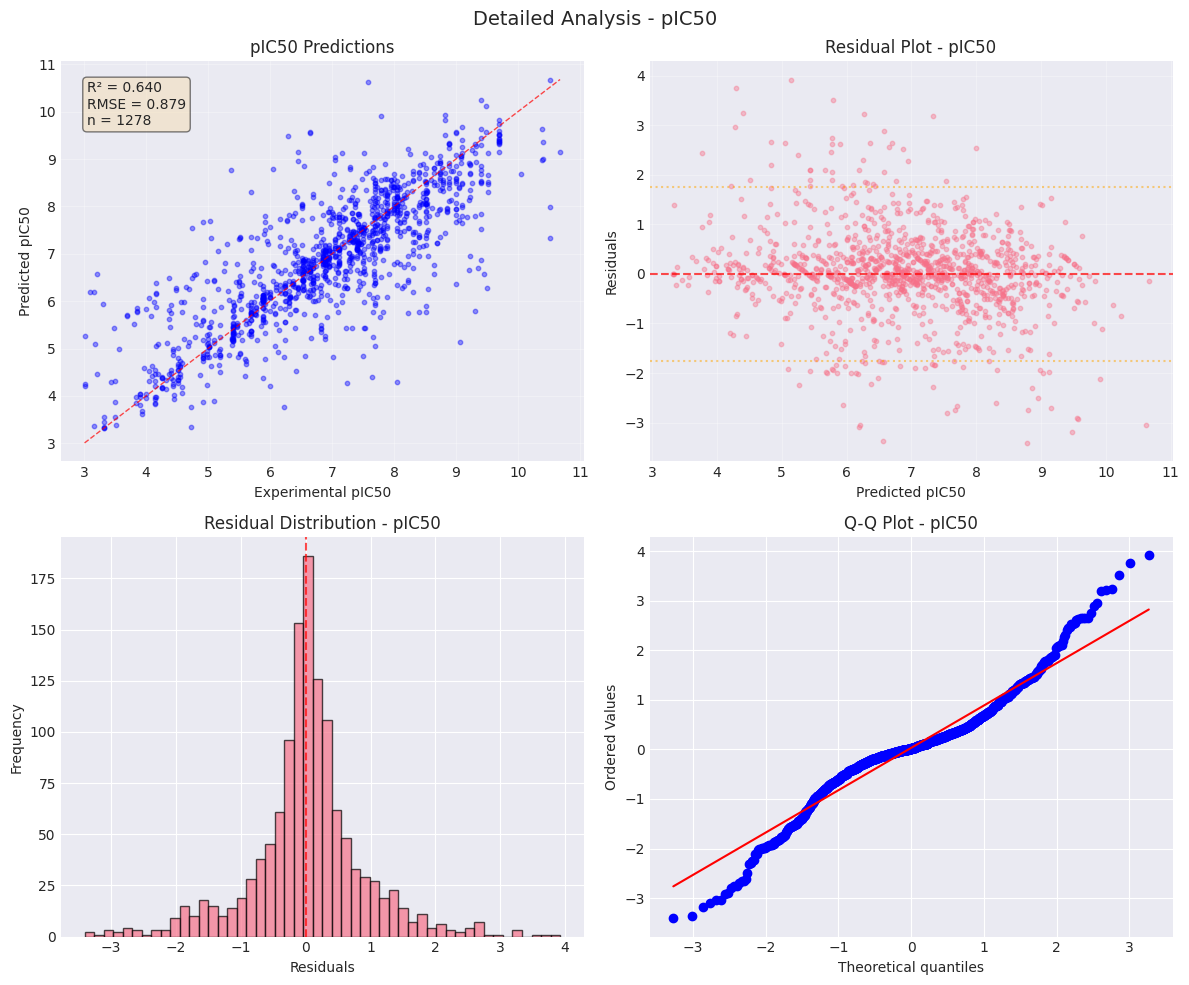

In [24]:
# Analyze prediction errors
if 'cv_results' in locals():
    for task in CONFIG['task_cols']:
        if len(cv_results[task]['all_targets']) > 0:
            targets = np.array(cv_results[task]['all_targets'])
            preds = np.array(cv_results[task]['all_predictions'])
            
            # Calculate residuals
            residuals = targets - preds
            
            # Create figure with subplots
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            
            # 1. Predictions vs Targets
            ax = axes[0, 0]
            from gnn_dta_mtl.evaluation.visualization import plot_predictions
            plot_predictions(targets, preds, task, ax)
            
            # 2. Residuals plot
            ax = axes[0, 1]
            from gnn_dta_mtl.evaluation.visualization import plot_residuals
            plot_residuals(targets, preds, task, ax)
            
            # 3. Residual distribution
            ax = axes[1, 0]
            ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
            ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)
            ax.set_xlabel('Residuals')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Residual Distribution - {task}')
            
            # 4. Q-Q plot
            ax = axes[1, 1]
            from scipy import stats
            stats.probplot(residuals, dist="norm", plot=ax)
            ax.set_title(f'Q-Q Plot - {task}')
            
            plt.suptitle(f'Detailed Analysis - {task}', fontsize=14)
            plt.tight_layout()
            plt.savefig(
                os.path.join(CONFIG['experiment_dir'], 'figures', f'analysis_{task}.png'),
                dpi=300, bbox_inches='tight'
            )
            plt.show()

In [25]:
# Cell 14: Bootstrap Analysis
from gnn_dta_mtl.evaluation.metrics import bootstrap_metrics

if 'cv_results' in locals():
    print("\nBootstrap Confidence Intervals (95%):")
    
    for task in CONFIG['task_cols']:
        if len(cv_results[task]['all_targets']) > 0:
            targets = np.array(cv_results[task]['all_targets'])
            preds = np.array(cv_results[task]['all_predictions'])
            
            # Calculate bootstrap CIs
            boot_results = bootstrap_metrics(
                targets, preds,
                n_bootstrap=1000,
                confidence=0.95,
                seed=SEED
            )
            
            print(f"\n{task}:")
            for metric, (mean, lower, upper) in boot_results.items():
                print(f"  {metric}: {mean:.3f} [{lower:.3f}, {upper:.3f}]")


Bootstrap Confidence Intervals (95%):

pKi:
  rmse: 1.080 [1.078, 1.083]
  r2: 0.661 [0.659, 0.662]
  mae: 0.717 [0.716, 0.719]

pEC50:
  rmse: 0.760 [0.756, 0.763]
  r2: 0.786 [0.784, 0.789]
  mae: 0.516 [0.513, 0.519]

pKd:
  rmse: 0.993 [0.989, 0.998]
  r2: 0.713 [0.711, 0.715]
  mae: 0.610 [0.609, 0.612]

pIC50:
  rmse: 0.879 [0.877, 0.881]
  r2: 0.640 [0.638, 0.641]
  mae: 0.592 [0.591, 0.593]


Model Statistics:
  Total parameters: 3,438,484
  Model size: 13.12 MB


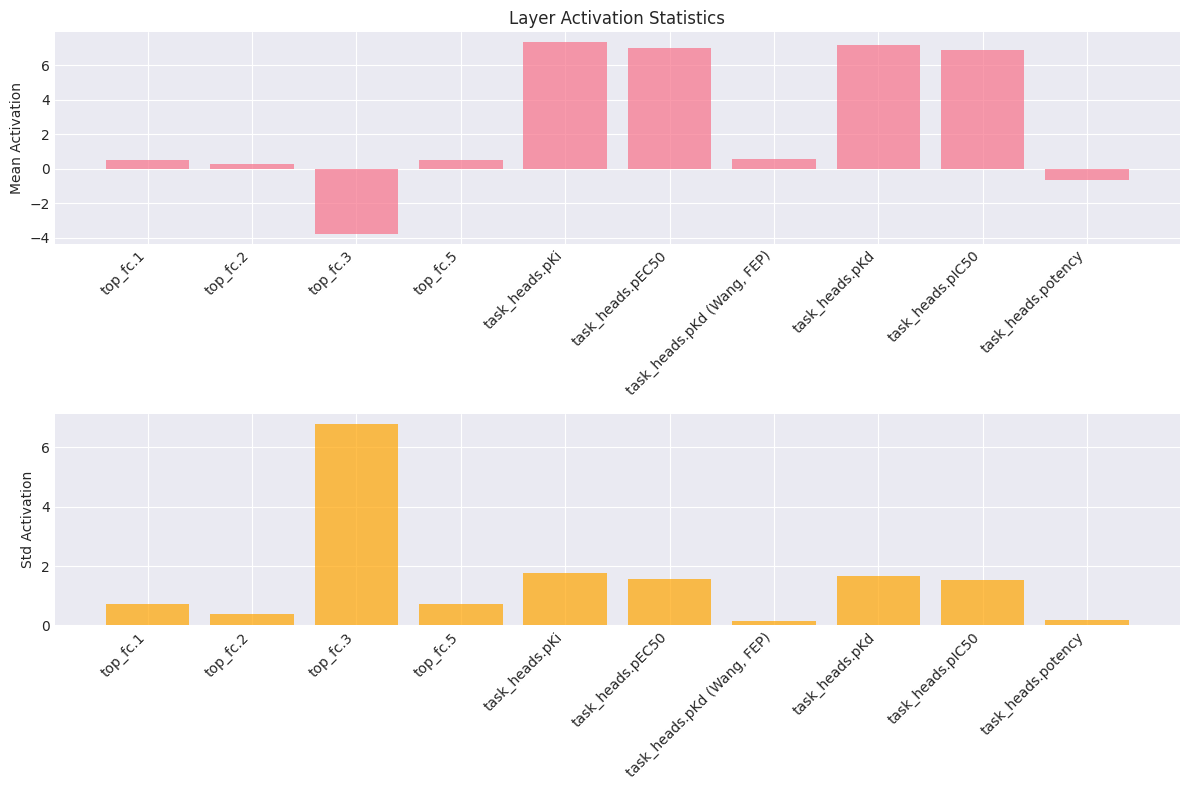

In [26]:
# Cell 15: Analyze Model Features
if 'model' in locals():
    from gnn_dta_mtl.utils.model_utils import (
        count_parameters, 
        get_model_size,
        get_activation_stats
    )
    
    # Model statistics
    n_params = count_parameters(model)
    model_size = get_model_size(model)
    
    print("Model Statistics:")
    print(f"  Total parameters: {n_params:,}")
    print(f"  Model size: {model_size['total_size_mb']:.2f} MB")
    
    # Get activation statistics
    if 'test_loader' in locals():
        act_stats = get_activation_stats(model, test_loader, device)
        
        # Visualize activation statistics
        layers = list(act_stats.keys())[-10:]  # Last 10 layers
        means = [act_stats[l]['mean'] for l in layers]
        stds = [act_stats[l]['std'] for l in layers]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        x = range(len(layers))
        ax1.bar(x, means, alpha=0.7)
        ax1.set_xticks(x)
        ax1.set_xticklabels(layers, rotation=45, ha='right')
        ax1.set_ylabel('Mean Activation')
        ax1.set_title('Layer Activation Statistics')
        
        ax2.bar(x, stds, alpha=0.7, color='orange')
        ax2.set_xticks(x)
        ax2.set_xticklabels(layers, rotation=45, ha='right')
        ax2.set_ylabel('Std Activation')
        
        plt.tight_layout()
        plt.savefig(
            os.path.join(CONFIG['experiment_dir'], 'figures', 'activation_stats.png'),
            dpi=300, bbox_inches='tight'
        )
        plt.show()

# Export


In [27]:
# Cell 16: Export Final Results
import json
from datetime import datetime

# Compile all results
final_results = {
    'experiment_name': experiment_name,
    'timestamp': datetime.now().isoformat(),
    'config': CONFIG,
    'data_stats': {
        'total_samples': len(df),
        'train_samples': len(df_train) if 'df_train' in locals() else None,
        'valid_samples': len(df_valid) if 'df_valid' in locals() else None,
        'test_samples': len(df_test) if 'df_test' in locals() else None
    }
}

# Add CV results summary
if 'cv' in locals() and hasattr(cv, 'summary'):
    final_results['cv_summary'] = cv.summary

# Add test results
if 'test_results' in locals():
    final_results['test_results'] = test_results

# Save comprehensive report
report_path = os.path.join(CONFIG['experiment_dir'], 'final_report.json')
with open(report_path, 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\nFinal report saved to: {report_path}")
print(f"All results saved in: {CONFIG['experiment_dir']}")

# Create LaTeX table for publication
if 'cv' in locals() and hasattr(cv, 'summary'):
    print("\nLaTeX Table for Publication:")
    print("\\begin{table}[h]")
    print("\\centering")
    print("\\begin{tabular}{lcccc}")
    print("\\hline")
    print("Task & R² & RMSE & MAE & N \\\\")
    print("\\hline")
    
    for task, metrics in cv.summary.items():
        print(f"{task} & "
              f"{metrics['r2_mean']:.3f}$\\pm${metrics['r2_std']:.3f} & "
              f"{metrics['rmse_mean']:.3f}$\\pm${metrics['rmse_std']:.3f} & "
              f"- & "
              f"{metrics['n_samples']} \\\\")
    
    print("\\hline")
    print("\\end{tabular}")
    print("\\caption{Cross-validation results for multi-task drug-target affinity prediction}")
    print("\\end{table}")


Final report saved to: ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/final_report.json
All results saved in: ../output/experiments/gnn_dta_mtl_experiment_20250910_153508

LaTeX Table for Publication:
\begin{table}[h]
\centering
\begin{tabular}{lcccc}
\hline
Task & R² & RMSE & MAE & N \\
\hline
pKi & 0.659$\pm$0.039 & 1.079$\pm$0.062 & - & 1383 \\
pEC50 & 0.785$\pm$0.036 & 0.758$\pm$0.051 & - & 183 \\
pKd & 0.717$\pm$0.069 & 0.985$\pm$0.170 & - & 952 \\
pIC50 & 0.642$\pm$0.067 & 0.873$\pm$0.085 & - & 1278 \\
\hline
\end{tabular}
\caption{Cross-validation results for multi-task drug-target affinity prediction}
\end{table}


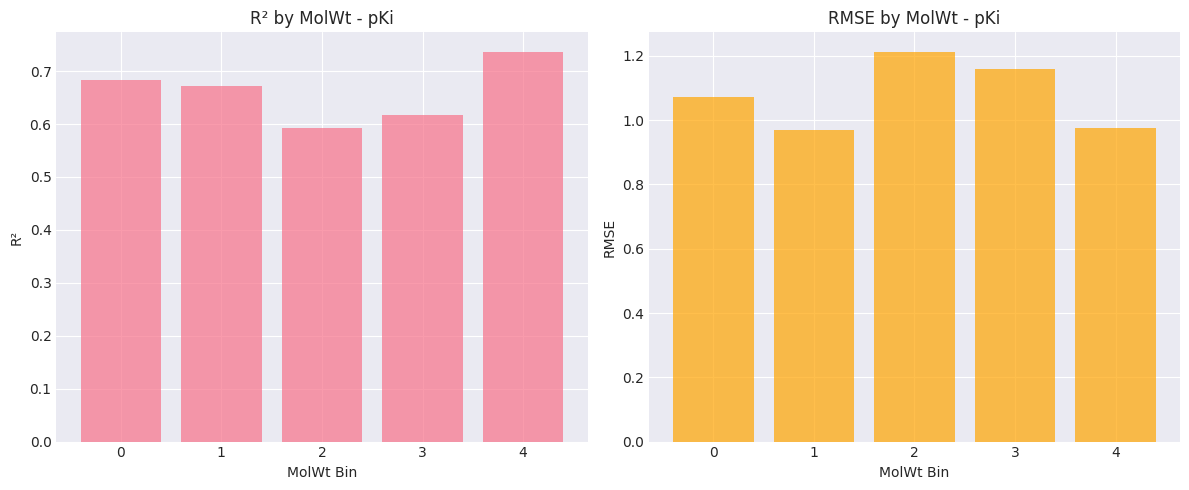

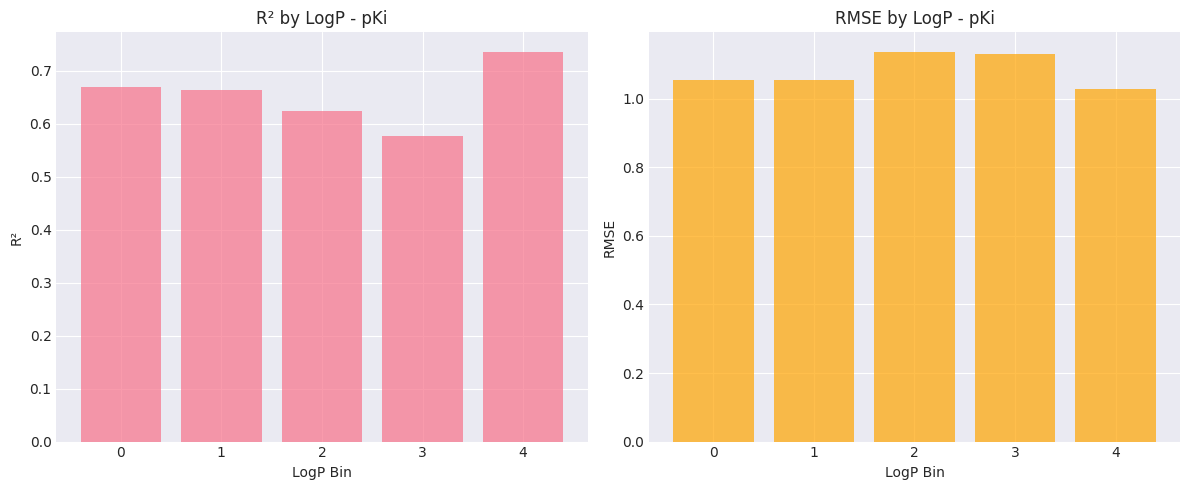

In [28]:
# Cell 17: Interactive Analysis Functions
def analyze_predictions_by_property(task, property_col='MolWt', n_bins=5):
    """Analyze predictions by molecular property"""
    if task not in cv_results or len(cv_results[task]['all_targets']) == 0:
        print(f"No results for {task}")
        return
    
    # Get predictions and targets
    targets = np.array(cv_results[task]['all_targets'])
    preds = np.array(cv_results[task]['all_predictions'])
    
    # Get property values (need to match with original df)
    # This assumes df is still aligned with cv_results
    property_values = df[property_col].values[:len(targets)]
    
    # Create bins
    bins = pd.qcut(property_values, n_bins, labels=False, duplicates='drop')
    
    # Calculate metrics per bin
    from sklearn.metrics import r2_score, mean_squared_error
    
    results = []
    for bin_idx in range(n_bins):
        mask = bins == bin_idx
        if mask.sum() > 0:
            r2 = r2_score(targets[mask], preds[mask])
            rmse = np.sqrt(mean_squared_error(targets[mask], preds[mask]))
            results.append({
                'bin': bin_idx,
                'n_samples': mask.sum(),
                'r2': r2,
                'rmse': rmse,
                f'{property_col}_mean': property_values[mask].mean()
            })
    
    results_df = pd.DataFrame(results)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.bar(results_df['bin'], results_df['r2'], alpha=0.7)
    ax1.set_xlabel(f'{property_col} Bin')
    ax1.set_ylabel('R²')
    ax1.set_title(f'R² by {property_col} - {task}')
    
    ax2.bar(results_df['bin'], results_df['rmse'], alpha=0.7, color='orange')
    ax2.set_xlabel(f'{property_col} Bin')
    ax2.set_ylabel('RMSE')
    ax2.set_title(f'RMSE by {property_col} - {task}')
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Example usage
if 'cv_results' in locals():
    for task in CONFIG['task_cols'][:1]:  # Analyze first task
        results_by_mw = analyze_predictions_by_property(task, 'MolWt')
        results_by_logp = analyze_predictions_by_property(task, 'LogP')

In [29]:
# Cell 18: Save Session State
import pickle

# Save important objects
session_state = {
    'config': CONFIG,
    'task_ranges': task_ranges,
    'cv_results': cv_results if 'cv_results' in locals() else None,
    'test_results': test_results if 'test_results' in locals() else None,
    'df_stats': {
        'shape': df.shape,
        'columns': df.columns.tolist(),
        'task_coverage': {task: df[task].notna().sum() for task in CONFIG['task_cols']}
    }
}

session_path = os.path.join(CONFIG['experiment_dir'], 'session_state.pkl')
with open(session_path, 'wb') as f:
    pickle.dump(session_state, f)

print(f"Session state saved to: {session_path}")
print("\nTo restore session in a new notebook:")
print(f"with open('{session_path}', 'rb') as f:")
print("    session_state = pickle.load(f)")

Session state saved to: ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/session_state.pkl

To restore session in a new notebook:
with open('../output/experiments/gnn_dta_mtl_experiment_20250910_153508/session_state.pkl', 'rb') as f:
    session_state = pickle.load(f)


In [30]:
1

1